# Identificación de topicos de investigación en el CIAT

In [122]:
%load_ext autoreload
%autoreload 2
from read_files import *
import numpy as np
import matplotlib.pyplot as plt 
import gensim
from gensim.models import CoherenceModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Lectura de datos
 para leer los datos, se crea una función que explora todas las subcarpetas dentro de una carpeta, y aplica la función personalizada *clean_tokenize*, para ello importamos todas las funciones de nuestro archivo *read_files.py*, esta función toma cada documento y le realiza los siguientes procesamientos

 * Convertir en minusculas el texto
 * Eliminar paginas web, signos de puntuación y espacios en blanco.
 * Tokenizar el texto
 * Eliminar Stop Words
 * Lematizacion
 
Estos resultados estan sujetos al rendimiento de la libreria NLTK, la cual es de las mas potentes para procesamiento de lenguaje natural.

Adicionalmente, cualquier stopword que se identifique se debe adicionar el en archivo *stop_words.csv* para que sea excluida del análisis

In [78]:
data = get_data("data/CIAT/")
df = data[data['topic']=='Investigaciòn'] # Solo investigación
print("Numero de documentos: "+ str(df.shape[0]))
df.head()

Numero de documentos: 61


,document,topic,file,clean_text
0,About research on Agrobiodiversity in CIAT\nDe...,Investigaciòn,Investigacion 1.txt,"[agrobiodiversity, delivering, next, generatio..."
1,Tropical Soils Biology Fertility Institute (TS...,Investigaciòn,Investigacion 10.txt,"[tropical, soil, biology, fertility, institute..."
2,The Participatory Research for Development in ...,Investigaciòn,investigacion 11.txt,"[participatory, development, upland, prdu, pro..."
3,Cassava\nUp to 1998 cassava research in LAC wa...,Investigaciòn,investigacion 13.txt,"[cassava, cassava, lac, led, collaboration, na..."
4,"New research at CIAT, using “next-generation\n...",Investigaciòn,Investigacion 14.txt,"[new, using, next, generation, rad, sequencing..."


* **document:** contiene todo el texto original del documento
* **topic:** contiene el topico de cada documento (se toma de la carpeta)
* **file:** contiene el nombre del archivo que contiene el texto
* **clean_text:** contiene el texto limpio y tokenizado, resultante de aplicar la función *clean_tokenize*

## Visualización de datos (Nube de palabras) por documento
En esta sección queremos visualizar las palabras presentes en nuestro documento

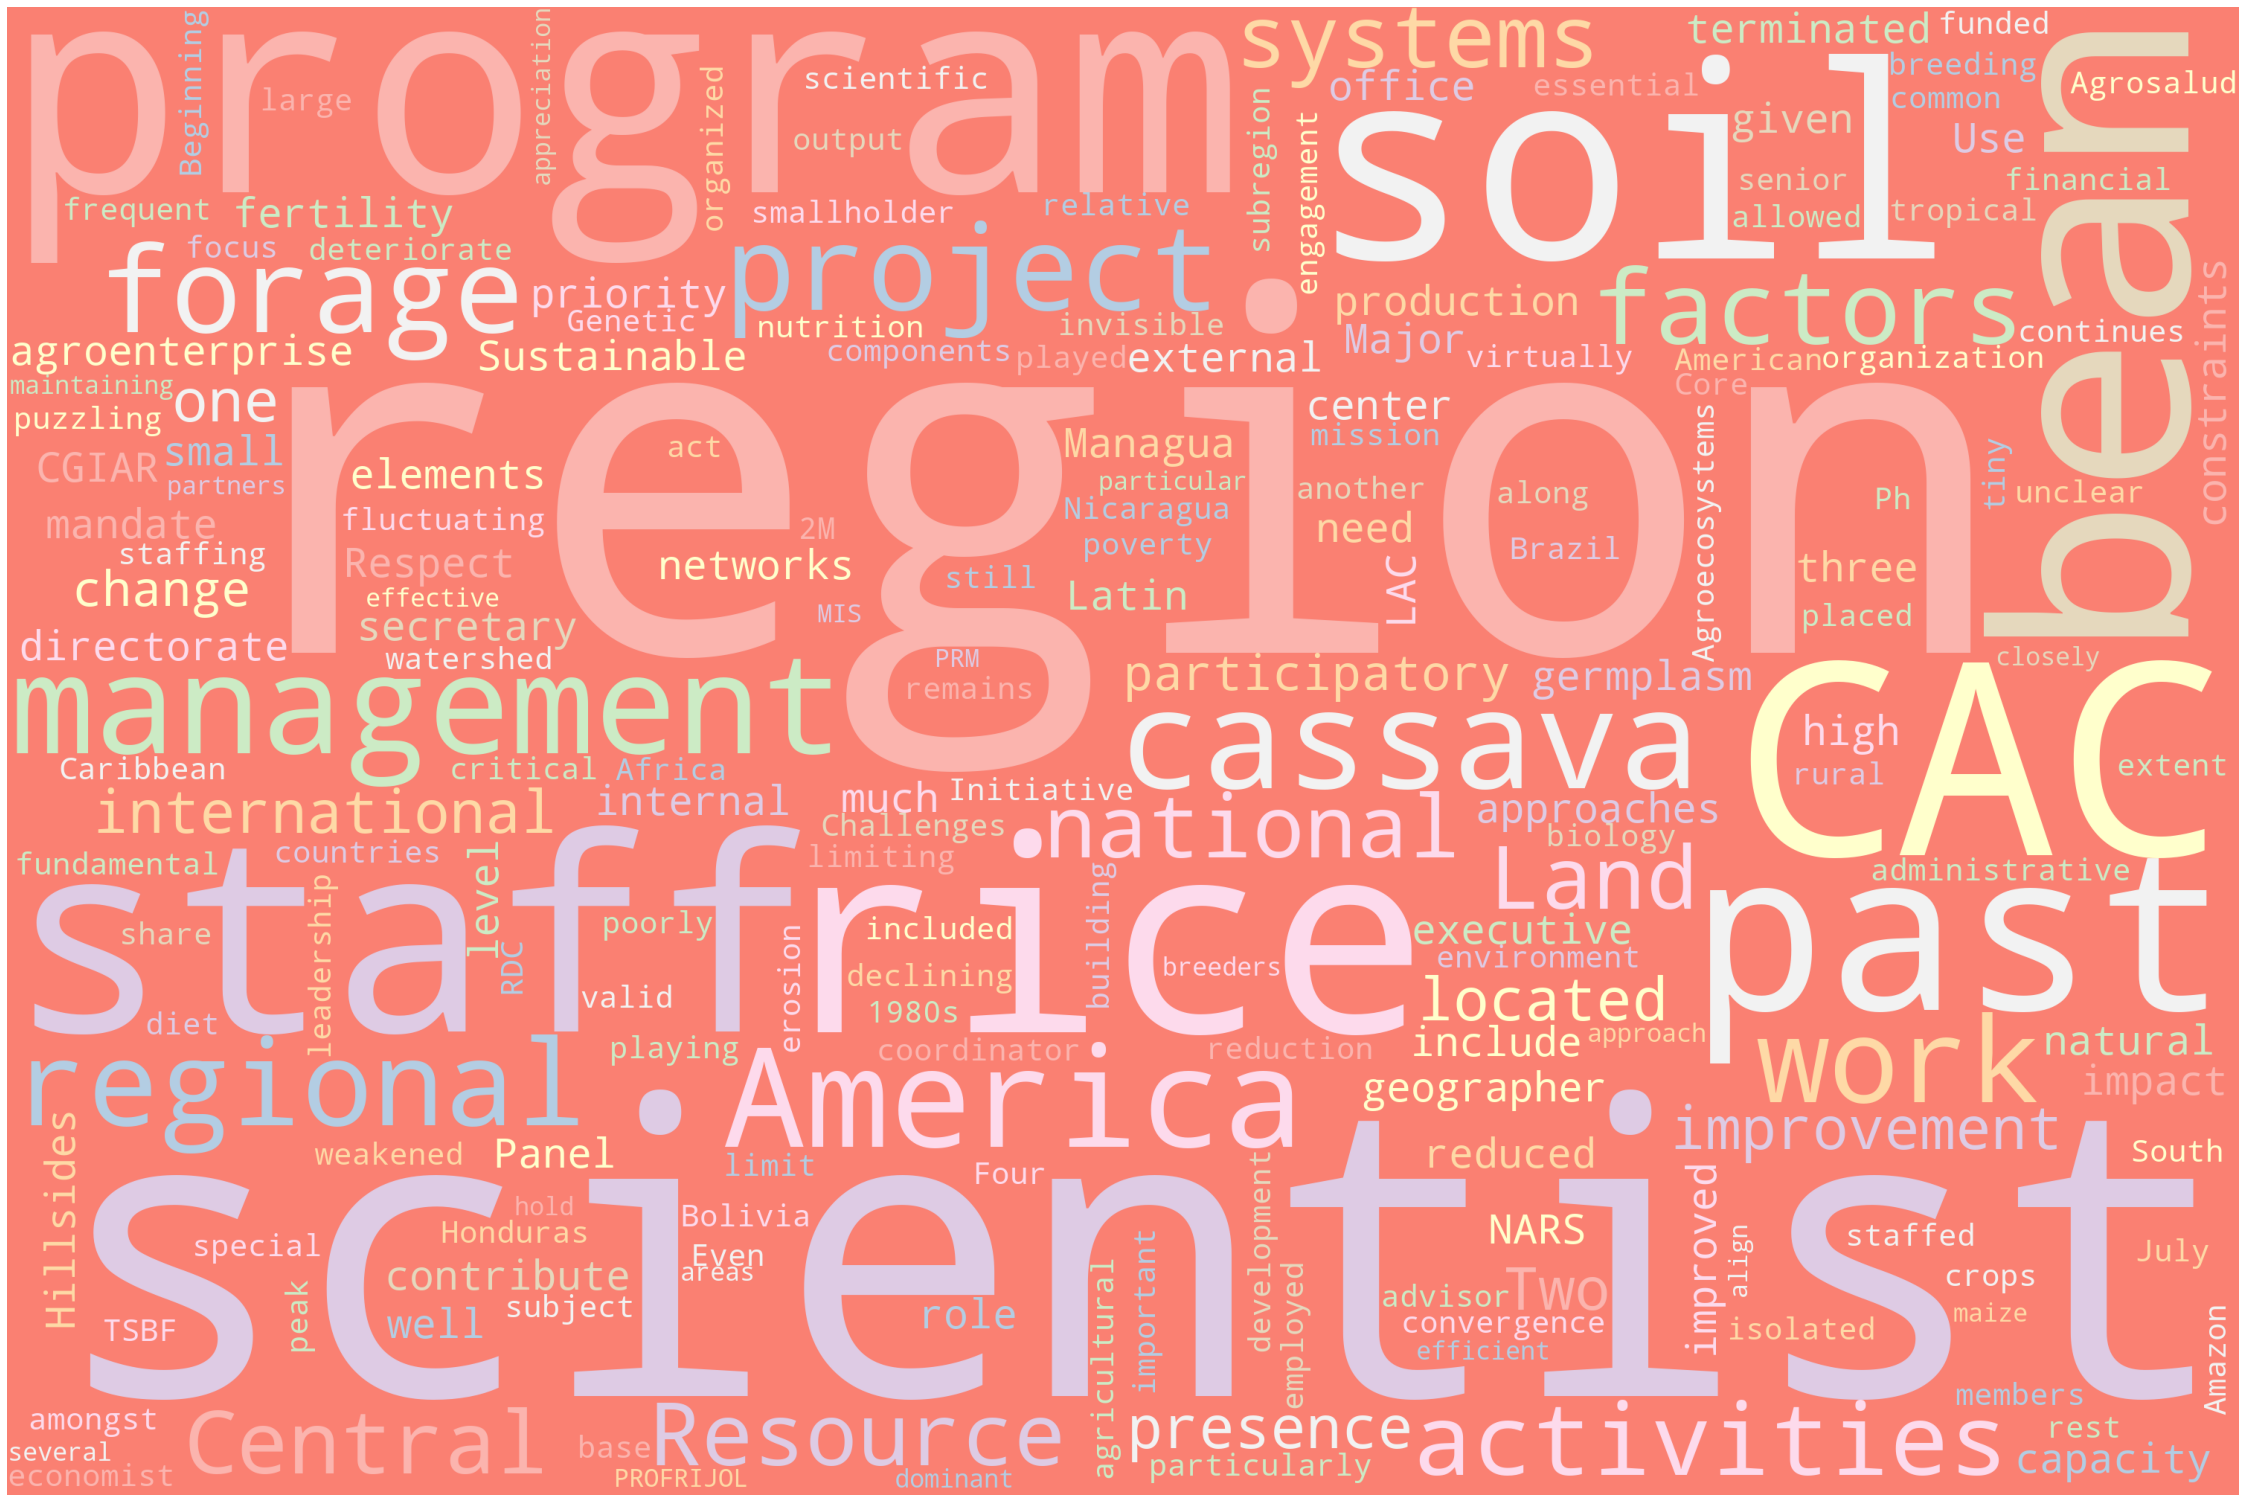

In [87]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
new_stop = pd.read_csv('stop_words.csv')
    # lista de stop words en español
stop_words = stopwords.words('english')
stop_words.extend(new_stop['palabra'])
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, 
                background_color='salmon', colormap='Pastel1', 
                collocations=False, stopwords = stop_words).generate(df['document'][60]) ## Seleccione aqui documento del 0-60
plot_cloud(wordcloud)

In [123]:
textos = ",".join(list(df['document'].values))

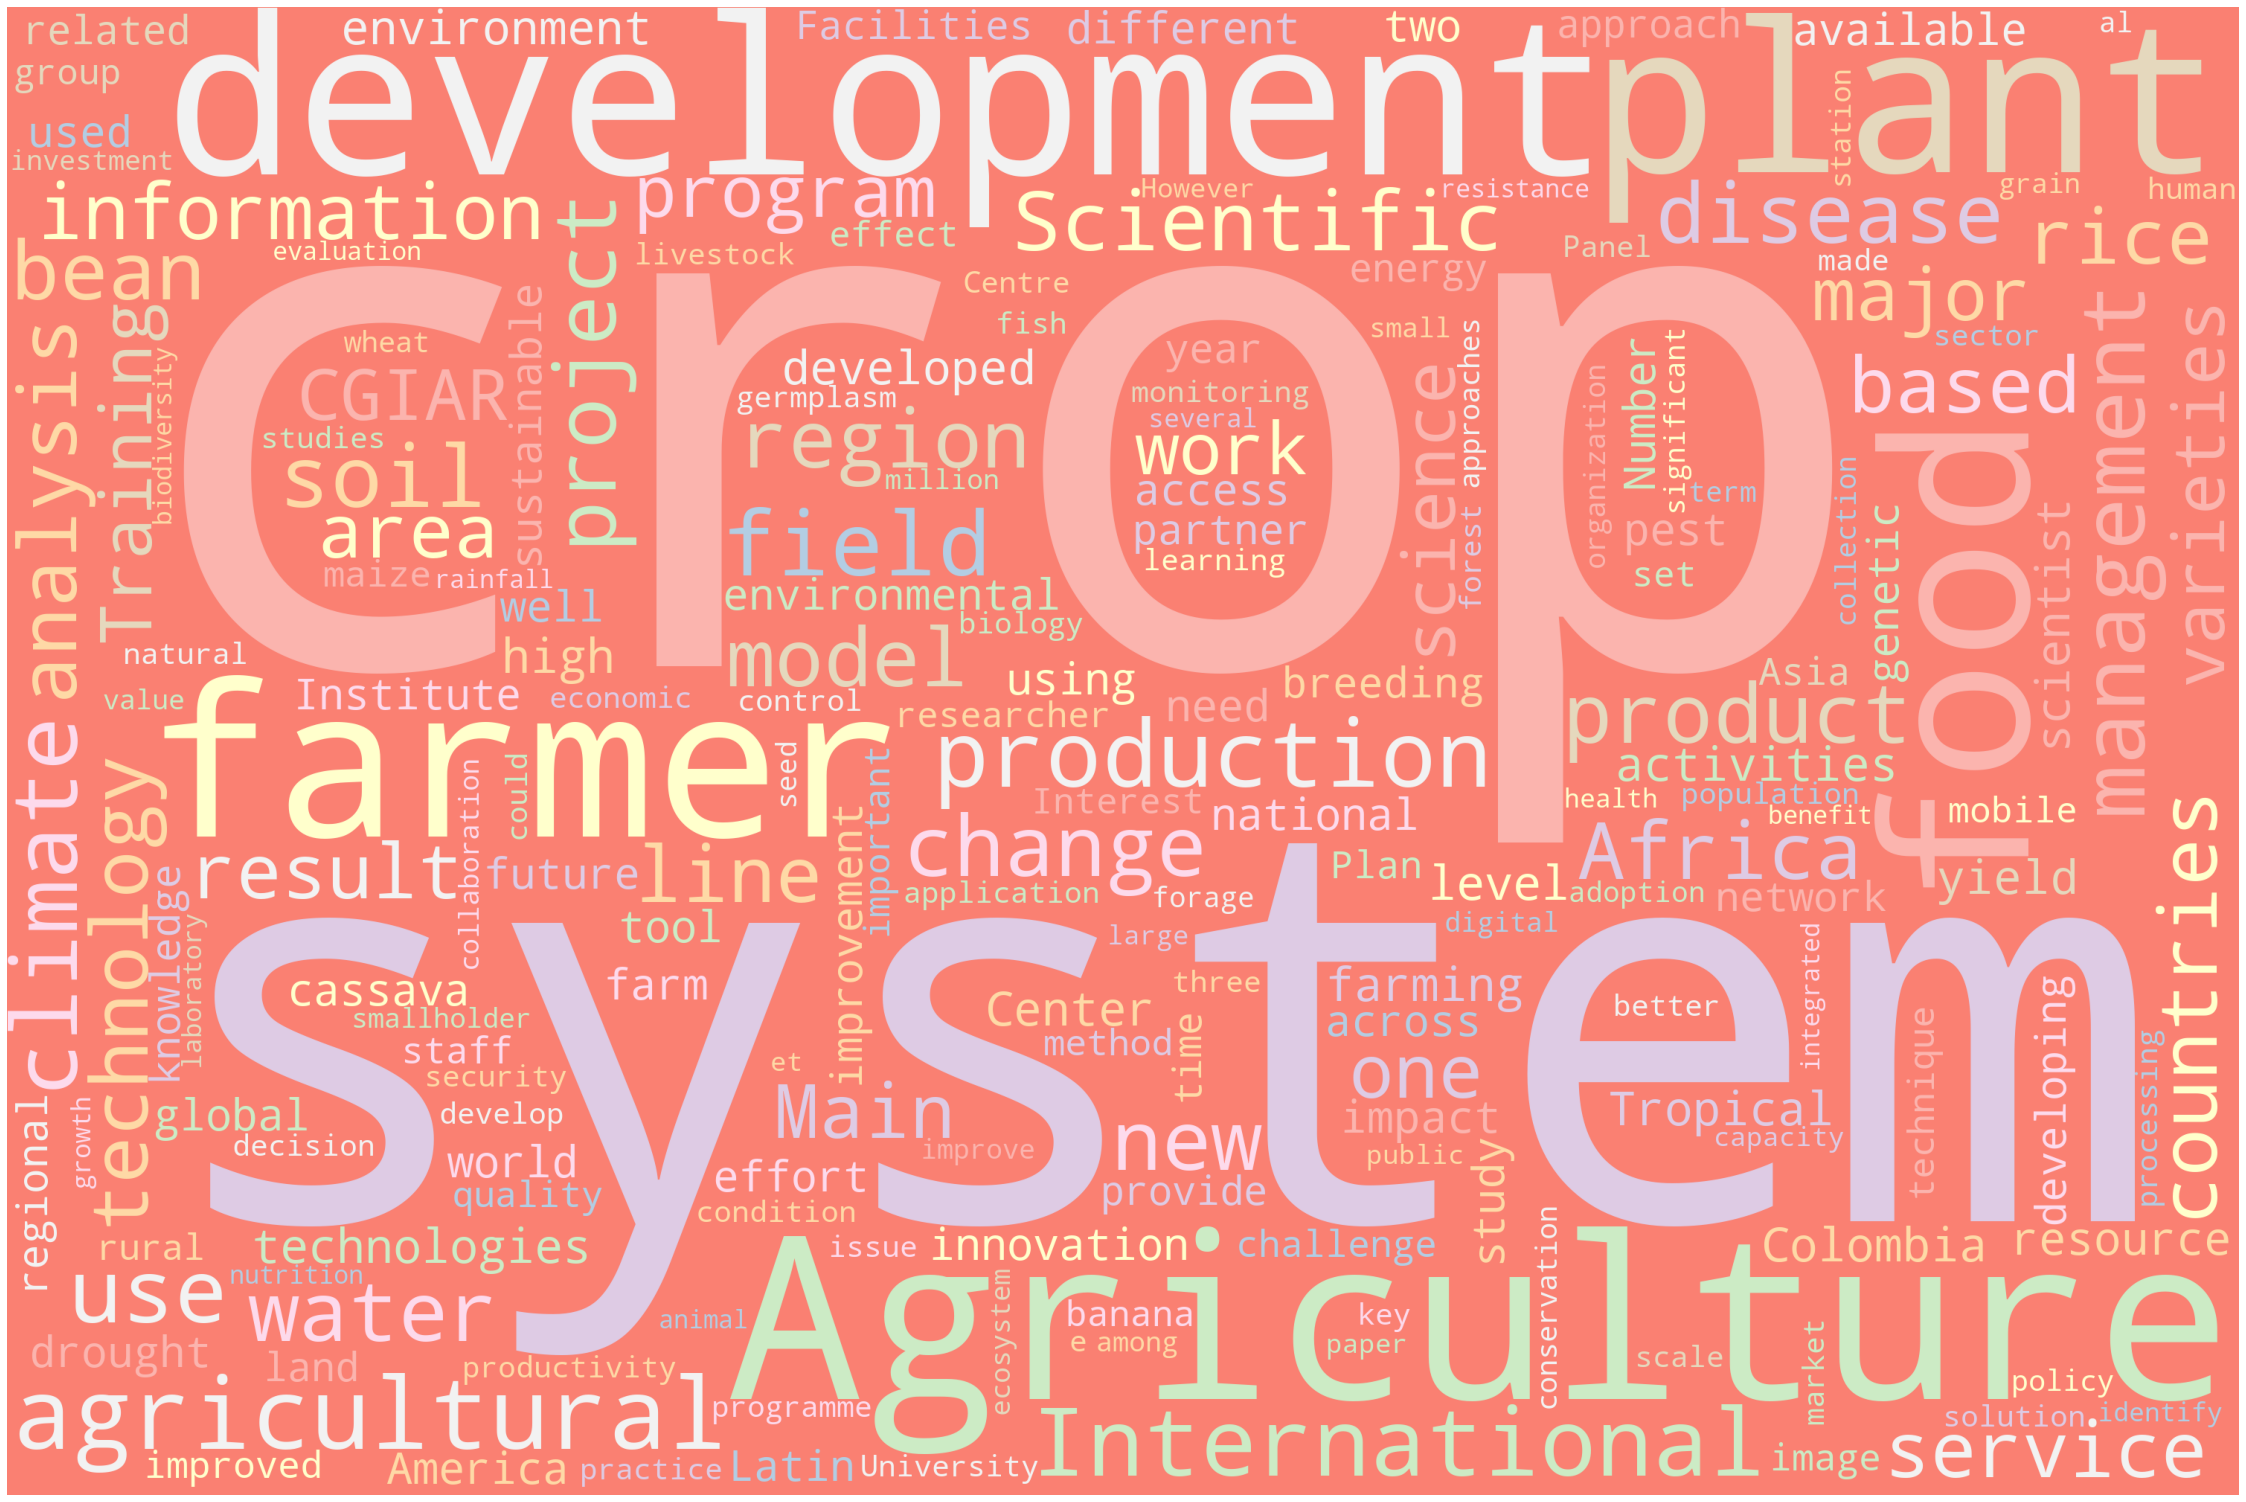

In [125]:
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, 
                background_color='salmon', colormap='Pastel1', 
                collocations=False, stopwords = stop_words).generate(textos) ## Seleccione aqui documento del 0-60
plot_cloud(wordcloud)

# Iniciando con el modelo LDA

In [89]:
#Creando el diccionario
dictionary = gensim.corpora.Dictionary(df['clean_text'])

  
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 accelerate
1 access
2 accessible
3 according
4 accuracy
5 accurately
6 achieve
7 across
8 action
9 activity
10 addition


In [90]:
#Creación del corpus
corpus = [dictionary.doc2bow(text) for text in df['clean_text']]
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accelerate', 1),
  ('access', 2),
  ('accessible', 1),
  ('according', 1),
  ('accuracy', 2),
  ('accurately', 1),
  ('achieve', 1),
  ('across', 3),
  ('action', 3),
  ('activity', 1),
  ('addition', 1),
  ('address', 3),
  ('advise', 1),
  ('affect', 1),
  ('afford', 1),
  ('afield', 1),
  ('africa', 3),
  ('ago', 1),
  ('agreed', 1),
  ('agricultural', 13),
  ('agriculture', 17),
  ('agrobiodiversity', 2),
  ('agronomy', 1),
  ('agrotutor', 3),
  ('ahead', 1),
  ('ai', 2),
  ('aim', 1),
  ('alarcón', 1),
  ('alliance', 5),
  ('allied', 1),
  ('almost', 1),
  ('along', 1),
  ('alongside', 1),
  ('already', 3),
  ('alternative', 1),
  ('although', 2),
  ('always', 2),
  ('america', 6),
  ('among', 1),
  ('amount', 1),
  ('amounted', 1),
  ('analysis', 4),
  ('analyst', 1),
  ('analytics', 6),
  ('analyzed', 2),
  ('ancestral', 1),
  ('ancient', 2),
  ('andean', 1),
  ('android', 1),
  ('app', 10),
  ('appeared', 1),
  ('application', 4),
  ('applied', 2),
  ('applying', 1),
  ('ap

In [91]:
#Función para encontrar los parametros optimos del modelo k, alpha, beta
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df['clean_text'], dictionary=dictionary, coherence='c_v')
    per=lda_model.log_perplexity(corpus)
    return coherence_model_lda.get_coherence(),per

In [104]:
import numpy as np
import tqdm

grid = {}

# Topics range
min_topics = 2
max_topics =10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.1,0.5, 0.1))
#alpha.append('symmetric')
#alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.2, 0.5, 0.1))
#beta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': [],
                 'Perplejidad': []
                }

In [105]:
# iterate through number of topics
for k in topics_range:
# iterate through alpha values
    for a in alpha:
 # iterare through beta values
        for b in beta:
            cv = compute_coherence_values(corpus=corpus, dictionary=dictionary,k=k, a=a, b=b)
            # Save the model results
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv[0])
            model_results['Perplejidad'].append(cv[1]) 
            
Resultados=pd.DataFrame(model_results)

In [108]:
Resultados[Resultados['Coherence'] == Resultados['Coherence'].max()]

,Topics,Alpha,Beta,Coherence,Perplejidad
93,9,0.4,0.2,0.442735,-7.885111


In [116]:
Resultados[Resultados['Coherence'] >= 0.4]

,Topics,Alpha,Beta,Coherence,Perplejidad
1,2,0.1,0.3,0.401381,-7.894250
8,2,0.3,0.4,0.401381,-7.886601
11,2,0.4,0.4,0.401381,-7.887384
36,5,0.1,0.2,0.418567,-7.899769
37,5,0.1,0.3,0.403645,-7.888367
38,5,0.1,0.4,0.403645,-7.894344
39,5,0.2,0.2,0.418567,-7.902827
40,5,0.2,0.3,0.400891,-7.891284
41,5,0.2,0.4,0.403645,-7.897042
42,5,0.3,0.2,0.418567,-7.905178


In [117]:
k=5
a=0.2
b=0.2
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)

chunksize controla cuántos documentos se procesan a la vez en el algoritmo de entrenamiento. Aumentar el tamaño de los fragmentos acelerará el entrenamiento, al menos mientras el fragmento de documentos quepa fácilmente en la memoria.
pass controla la frecuencia con la que entrenamos el modelo en todo el corpus (establecido en 10). Otra palabra para pases podría ser "épocas". iteraciones es algo técnico, pero esencialmente controla la frecuencia con la que repetimos un ciclo particular sobre cada documento. Es importante establecer el número de "pasos" e "iteraciones" lo suficientemente alto.

In [118]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.9028271549469045


In [119]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['clean_text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.41856652586928


In [120]:
#Modulos para los graifcos
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

In [121]:
# Visualize the topics

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus,dictionary)
vis

/home/wilmar3752/anaconda3/envs/nlp/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.083447  0.102770       1        1  26.339854
4      0.049299 -0.005189       2        1  25.821688
3     -0.011609 -0.072324       3        1  24.593018
1     -0.070424 -0.058554       4        1  16.784526
0      0.116180  0.033297       5        1   6.460914, topic_info=            Term        Freq       Total Category  logprob  loglift
1435    training   75.000000   75.000000  Default  30.0000  30.0000
744   scientific   93.000000   93.000000  Default  29.0000  29.0000
1176        main   81.000000   81.000000  Default  28.0000  28.0000
1290        soil  107.000000  107.000000  Default  27.0000  27.0000
3389  laboratory   49.000000   49.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
894      variety    8.042656   95.592711   Topic5  -5.6924   0.2641
878   university    6.552226   45.692710   Topic5  -5.8974   0.7973
1489    facility    6.675994   51.017156   Topic5  -5.8786   0.7058
496         line    7.483281   88.977434   Topic5  -5.7645   0.2637
718       result    6.809422   85.347079   Topic5  -5.8589   0.2110

[397 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1         1  0.207976     access
1         2  0.623928     access
1         3  0.086657     access
1         4  0.086657     access
2110      3  0.949919  accession
...     ...       ...        ...
932       2  0.391277      yield
932       3  0.418262      yield
932       4  0.026985      yield
932       5  0.026985      yield
5295      3  0.945078     znseed

[794 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 2, 1])

El control deslizante λ permite clasificar los términos según su relevancia. De forma predeterminada,
los términos de un tema se clasifican en orden decreciente según su probabilidad específica del tema ( λ = 1 ). 
Mover el control deslizante permite ajustar la clasificación de los términos según su grado de discriminación 
(o "relevancia") para el tema específico. El valor "óptimo" sugerido de λ es 0,6.

El mapa de distancia entre temas es una visualización de los temas en un espacio bidimensional.

El área de estos círculos de temas es proporcional a la cantidad de palabras que pertenecen a cada tema en el diccionario.

El gráfico de barras muestra por defecto los 30 términos más destacados. Las barras indican la frecuencia total del término en todo el corpus. 

Salient es una métrica específica, definida en la parte inferior de la visualización, 
que se puede considerar como una métrica utilizada para identificar las palabras más informativas 
o útiles para identificar temas en toda la colección de textos.

In [100]:
# Show topics
topics = lda_model.show_topics()
print(topics)

[(0, '0.007*"agriculture" + 0.007*"plant" + 0.007*"development" + 0.006*"crop" + 0.005*"system" + 0.005*"soil" + 0.005*"agricultural" + 0.005*"technology" + 0.005*"product" + 0.005*"field"'), (1, '0.007*"farmer" + 0.006*"system" + 0.006*"crop" + 0.005*"food" + 0.005*"technology" + 0.004*"agriculture" + 0.004*"disease" + 0.004*"climate" + 0.004*"development" + 0.004*"agricultural"')]


In [101]:
# Distribution of topics for the document
print(lda_model.get_document_topics(corpus[0]))
print(lda_model.get_document_topics(corpus[1]))
print(lda_model.get_document_topics(corpus[2]))
print(lda_model.get_document_topics(corpus[3]))
print(lda_model.get_document_topics(corpus[4]))
print(lda_model.get_document_topics(corpus[5]))
print(lda_model.get_document_topics(corpus[6]))
print(lda_model.get_document_topics(corpus[7]))
print(lda_model.get_document_topics(corpus[8]))
print(lda_model.get_document_topics(corpus[9]))
print(lda_model.get_document_topics(corpus[10]))
print(lda_model.get_document_topics(corpus[11]))
print(lda_model.get_document_topics(corpus[12]))
print(lda_model.get_document_topics(corpus[13]))

[(1, 0.9999483)]
[(1, 0.99991274)]
[(1, 0.9997318)]
[(1, 0.99980026)]
[(0, 0.99697524)]
[(0, 0.993139)]
[(0, 0.60691226), (1, 0.39308777)]
[(0, 0.7921867), (1, 0.20781331)]
[(1, 0.9999491)]
[(0, 0.9993711)]
[(0, 0.99857235)]
[(1, 0.9999666)]
[(0, 0.9997518)]
[(0, 0.9998842)]


In [102]:
corpus

[[(0, 1),
  (1, 2),
  (2, 1),
  (3, 1),
  (4, 2),
  (5, 1),
  (6, 1),
  (7, 3),
  (8, 3),
  (9, 1),
  (10, 1),
  (11, 3),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 3),
  (17, 1),
  (18, 1),
  (19, 13),
  (20, 17),
  (21, 2),
  (22, 1),
  (23, 3),
  (24, 1),
  (25, 2),
  (26, 1),
  (27, 1),
  (28, 5),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 3),
  (34, 1),
  (35, 2),
  (36, 2),
  (37, 6),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 4),
  (42, 1),
  (43, 6),
  (44, 2),
  (45, 1),
  (46, 2),
  (47, 1),
  (48, 1),
  (49, 10),
  (50, 1),
  (51, 4),
  (52, 2),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 3),
  (57, 1),
  (58, 1),
  (59, 2),
  (60, 4),
  (61, 1),
  (62, 2),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 6),
  (67, 1),
  (68, 2),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 2),
  (73, 1),
  (74, 2),
  (75, 13),
  (76, 1),
  (77, 1),
  (78, 2),
  (79, 1),
  (80, 3),
  (81, 5),
  (82, 3),
  (83, 2),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 5),
  (91

In [103]:
from pprint import pprint
# Imprimir la palabra clave
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"agriculture" + 0.007*"plant" + 0.007*"development" + 0.006*"crop" + '
  '0.005*"system" + 0.005*"soil" + 0.005*"agricultural" + 0.005*"technology" + '
  '0.005*"product" + 0.005*"field"'),
 (1,
  '0.007*"farmer" + 0.006*"system" + 0.006*"crop" + 0.005*"food" + '
  '0.005*"technology" + 0.004*"agriculture" + 0.004*"disease" + '
  '0.004*"climate" + 0.004*"development" + 0.004*"agricultural"')]
